In [6]:
# Install the packages
install.packages("ggplot2")
install.packages("dplyr")
install.packages("tidyr")
install.packages("readr")

library(ggplot2)
library(dplyr)
library(tidyr)
library(readr)


The downloaded binary packages are in
	/var/folders/x3/5gclj9rd6tj1rpgd5cwxqvy00000gn/T//RtmpKerPAb/downloaded_packages

The downloaded binary packages are in
	/var/folders/x3/5gclj9rd6tj1rpgd5cwxqvy00000gn/T//RtmpKerPAb/downloaded_packages

The downloaded binary packages are in
	/var/folders/x3/5gclj9rd6tj1rpgd5cwxqvy00000gn/T//RtmpKerPAb/downloaded_packages

The downloaded binary packages are in
	/var/folders/x3/5gclj9rd6tj1rpgd5cwxqvy00000gn/T//RtmpKerPAb/downloaded_packages



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
# Load datasets
allsubmissions <- read.csv("../results/data/NY_SubmissionsEnrichedExpanded.csv")
uniquesubmissions <- read.csv("../results/data/NY_UniqueComplaintsEnrichedExpanded.csv")

In [97]:
# STEP 1: BASIC REPORT

# Count the number of unique complaints (number of rows in uniquesubmissions)
unique_submission_count <- nrow(uniquesubmissions)

# Count the total number of submissions (number of rows in allsubmissions)
all_submission_count <- nrow(allsubmissions)

# Calculate the total number of rejected submissions across all unique complaints
rejected_submission_count <- sum(uniquesubmissions$Total.number.of.rejections.associated.with.this.CASENBR, na.rm = TRUE)

# Calculate the average number of rejections per unique complaint
average_rejections <- uniquesubmissions %>%
  summarize(avg_rejections = mean(Total.number.of.rejections.associated.with.this.CASENBR, na.rm = TRUE)) %>%
  pull(avg_rejections)  

# Find the maximum number of rejections for any single unique complaint
max_rejections <- uniquesubmissions %>%
  summarize(max_rejections = max(Total.number.of.rejections.associated.with.this.CASENBR, na.rm = TRUE)) %>%
  pull(max_rejections)  

# Filter unique complaints where all submissions were rejected
rejections_only <- uniquesubmissions %>%
  filter(Total.number.of.submissions.associated.with.this.CASENBR == Total.number.of.rejections.associated.with.this.CASENBR)

# Count the number of unique complaints where all submissions were rejected
rejections_only_count <- nrow(rejections_only)

# Calculate the percentage of unique complaints where all submissions were rejected
percentage_rejection_only <- (rejections_only_count / unique_submission_count) * 100

# Calculate the average number of rejections for complaints with all submissions rejected
rej_only_average_rejections <- rejections_only %>%
  summarize(rej_only_avg = mean(Total.number.of.rejections.associated.with.this.CASENBR, na.rm = TRUE)) %>%
  pull(rej_only_avg)  

# Calculate the average number of days between first submission and last status update
average_days_between <- uniquesubmissions %>%
  summarize(avg_days_between = mean(`Days.between.initial.complaint.and.latest.status.assignment.for.this.CASENBR`, na.rm = TRUE)) %>%
  pull(avg_days_between)  

# Calculate the number of unique complaints Closed Granted or Accepted
unique_complaints_granted_or_accepted <- uniquesubmissions %>%
  filter(`Total.number.of.Closed.Granted.or.Closed.Accepted.status.updates.associated.with.this.CASENBR` > 0) %>%
  nrow()

# Calculate the number of unique complaints Closed Denied or Closed Other (but no Closed Granted or Accepted)
unique_complaints_denied_or_other <- uniquesubmissions %>%
  filter(
    `Total.number.of.Closed.Granted.or.Closed.Accepted.status.updates.associated.with.this.CASENBR` == 0 &
    `Total.number.of.Closed.Denied.or.Closed.Other.status.updates.associated.with.this.CASENBR` > 0
  ) %>%
  nrow()

# Count the number of unique complaints with all submissions rejected
unique_complaints_all_rejected <- nrow(rejections_only) 

# Create results data frame
reportresults <- data.frame(
  Description = c(
    "Total number of submissions",  
    "Number of unique complaints (distinct Remedy Case Numbers)",  
    "Number of rejected submissions across all submissions",  
    "Average number of rejections per unique case number",  
    "Max number of rejected submissions for a unique complaint",  
    "Number of unique complaints Closed Granted or Accepted",  
    "Number of unique complaints Closed Denied or Closed Other",  
    "Number of unique complaints with all submissions rejected",  
    "Average number of rejections per unique complaint with all submissions rejected", 
    "Average number of days between first submission and last status update for unique complaint" 
  ),
  Value = c(
    all_submission_count,  
    unique_submission_count,  
    rejected_submission_count,  
    average_rejections,  
    max_rejections,  
    unique_complaints_granted_or_accepted,  
    unique_complaints_denied_or_other,  
    unique_complaints_all_rejected,  
    rej_only_average_rejections,  
    average_days_between  
  ),
  stringsAsFactors = FALSE  # Avoid converting strings to factors
)

# Write the results to a CSV file
write.csv(reportresults, "../results/analysis/NY_GeneralReport.csv", row.names = FALSE, quote = TRUE)



In [98]:
# STEP 2: What is the breakdown of number of rejected submissions for a unique complaint?

# Group  unique complaints by the total number of rejections and count the number of complaints for each group
# Sort the counts in descending order
rejectionbreakdown <- uniquesubmissions %>%
  count(Total.number.of.rejections.associated.with.this.CASENBR, sort = TRUE) %>%
  # rename column headers
  rename(
    `total number of rejected submissions for a unique complaint` = Total.number.of.rejections.associated.with.this.CASENBR,
    `unique complaint count` = n
  )

# Save to a CSV file
write.csv(
  rejectionbreakdown, 
  "../results/analysis/NY_NumberOfRejectionsCount.csv", 
  row.names = FALSE,  # Do not include row names in the CSV file
)

In [99]:
# STEP 3: Analysis of Primary Remedy Subjects

primaryreasonbreakdown <- uniquesubmissions

# Make sure columns are numeric
primaryreasonbreakdown <- primaryreasonbreakdown %>%
  mutate(
    subcount = as.numeric(`Total.number.of.submissions.associated.with.this.CASENBR`),
    rejcount = as.numeric(`Total.number.of.rejections.associated.with.this.CASENBR`),
    cldclocount = as.numeric(`Total.number.of.Closed.Denied.or.Closed.Other.status.updates.associated.with.this.CASENBR`),
    clgacccount = as.numeric(`Total.number.of.Closed.Granted.or.Closed.Accepted.status.updates.associated.with.this.CASENBR`),
    only_rejected = ifelse(subcount == rejcount, 1, 0) 
  )

# Filter rows for Closed Granted/Accepted Counts
CLGACC <- primaryreasonbreakdown %>%
  filter(clgacccount > 0)

# Create a breakdown for Closed Granted/Accepted Counts
clgacc_breakdown <- CLGACC %>%
  count(`Primary.Remedy.Subject`, name = "Closed Granted/Accepted Count")

# Filter rows for Closed Denied/Closed Other Counts
CLDCLO <- primaryreasonbreakdown %>%
  filter(
    cldclocount >= 1, # Must have 1 or more Closed Denied/Closed Other statuses
    clgacccount == 0  # Must have 0 Closed Granted/Accepted statuses
  )

# Create a breakdown for Closed Denied/Closed Other Counts
cldclo_breakdown <- CLDCLO %>%
  count(`Primary.Remedy.Subject`, name = "Closed Denied/Closed Other Count")

# Merge the breakdowns into the primary dataset
primaryreasonbreakdown <- primaryreasonbreakdown %>%
  left_join(clgacc_breakdown, by = "Primary.Remedy.Subject") %>%
  left_join(cldclo_breakdown, by = "Primary.Remedy.Subject") %>%
  mutate(
    `Closed Granted/Accepted Count` = coalesce(`Closed Granted/Accepted Count`, 0),
    `Closed Denied/Closed Other Count` = coalesce(`Closed Denied/Closed Other Count`, 0)
  )

# Analyze the data to get the top primary subjects
analysis <- primaryreasonbreakdown %>%
  group_by(`Primary.Remedy.Subject`) %>%
  summarize(
    `Unique Complaint Count` = n(),
    `Percentage of All Unique Complaints` = round((`Unique Complaint Count` / nrow(primaryreasonbreakdown)) * 100, 2),
    `Closed Granted/Accepted Count` = first(`Closed Granted/Accepted Count`),
    `Closed Granted/Accepted Percentage` = round((`Closed Granted/Accepted Count` / `Unique Complaint Count`) * 100, 2),
    `Closed Denied/Closed Other Count` = first(`Closed Denied/Closed Other Count`),
    `Percentage Closed Denied/Closed Other` = round((`Closed Denied/Closed Other Count` / `Unique Complaint Count`) * 100, 2),
    `Rejected Only Count` = sum(only_rejected, na.rm = TRUE),
    `Percentage Rejected Only` = round((`Rejected Only Count` / `Unique Complaint Count`) * 100, 2)
  ) %>%
  arrange(desc(`Unique Complaint Count`)) # Sort descending

# Save the result to a CSV file
write.csv(analysis, paste0("../results/analysis/NY_PrimarySubjectAnalysis.csv"), row.names = FALSE, quote = TRUE)



In [100]:
# STEP 4: SECONDARY REMEDY CODE

# Read the data (reuse the original dataset to avoid confusion)
secondaryreasonbreakdown <- uniquesubmissions

# Ensure relevant columns are numeric
secondaryreasonbreakdown <- secondaryreasonbreakdown %>%
  mutate(
    subcount = as.numeric(`Total.number.of.submissions.associated.with.this.CASENBR`),
    rejcount = as.numeric(`Total.number.of.rejections.associated.with.this.CASENBR`),
    cldclocount = as.numeric(`Total.number.of.Closed.Denied.or.Closed.Other.status.updates.associated.with.this.CASENBR`),
    clgacccount = as.numeric(`Total.number.of.Closed.Granted.or.Closed.Accepted.status.updates.associated.with.this.CASENBR`),
    only_rejected = ifelse(subcount == rejcount, 1, 0) # Add column for only_rejected
  )

# Filter rows for Closed Granted/Accepted Counts
CLGACC_secondary <- secondaryreasonbreakdown %>%
  filter(clgacccount > 0)

# Create a breakdown for Closed Granted/Accepted Counts
clgacc_breakdown_secondary <- CLGACC_secondary %>%
  count(`Remedy.Subject.Code.Translation`, name = "Closed Granted/Accepted Count")

# Filter rows for Closed Denied/Closed Other Counts
CLDCLO_secondary <- secondaryreasonbreakdown %>%
  filter(
    cldclocount >= 1, # Must have 1 or more Closed Denied/Closed Other statuses
    clgacccount == 0  # Must have 0 Closed Granted/Accepted statuses
  )

# Create a breakdown for Closed Denied/Closed Other Counts
cldclo_breakdown_secondary <- CLDCLO_secondary %>%
  count(`Remedy.Subject.Code.Translation`, name = "Closed Denied/Closed Other Count")

# Merge the breakdowns into the secondary dataset
secondaryreasonbreakdown <- secondaryreasonbreakdown %>%
  left_join(clgacc_breakdown_secondary, by = "Remedy.Subject.Code.Translation") %>%
  left_join(cldclo_breakdown_secondary, by = "Remedy.Subject.Code.Translation") %>%
  mutate(
    `Closed Granted/Accepted Count` = coalesce(`Closed Granted/Accepted Count`, 0),
    `Closed Denied/Closed Other Count` = coalesce(`Closed Denied/Closed Other Count`, 0)
  )

# Analyze the data to get the top secondary subjects with desired columns
analysis_secondary <- secondaryreasonbreakdown %>%
  group_by(`Remedy.Subject.Code.Translation`) %>%
  summarize(
    `Unique Complaint Count` = n(),
    `Percentage of All Unique Complaints` = round((`Unique Complaint Count` / nrow(secondaryreasonbreakdown)) * 100, 2),
    `Closed Granted/Accepted Count` = first(`Closed Granted/Accepted Count`),
    `Closed Granted/Accepted Percentage` = round((`Closed Granted/Accepted Count` / `Unique Complaint Count`) * 100, 2),
    `Closed Denied/Closed Other Count` = first(`Closed Denied/Closed Other Count`),
    `Percentage Closed Denied/Closed Other` = round((`Closed Denied/Closed Other Count` / `Unique Complaint Count`) * 100, 2),
    `Rejected Only Count` = sum(only_rejected, na.rm = TRUE),
    `Percentage Rejected Only` = round((`Rejected Only Count` / `Unique Complaint Count`) * 100, 2)
  ) %>%
  arrange(desc(`Unique Complaint Count`)) # Sort by total complaints in descending order

# Save the result to a CSV file
write.csv(analysis_secondary, paste0("../results/analysis/NY_SecondarySubjectAnalysis.csv"), row.names = FALSE, quote = TRUE)


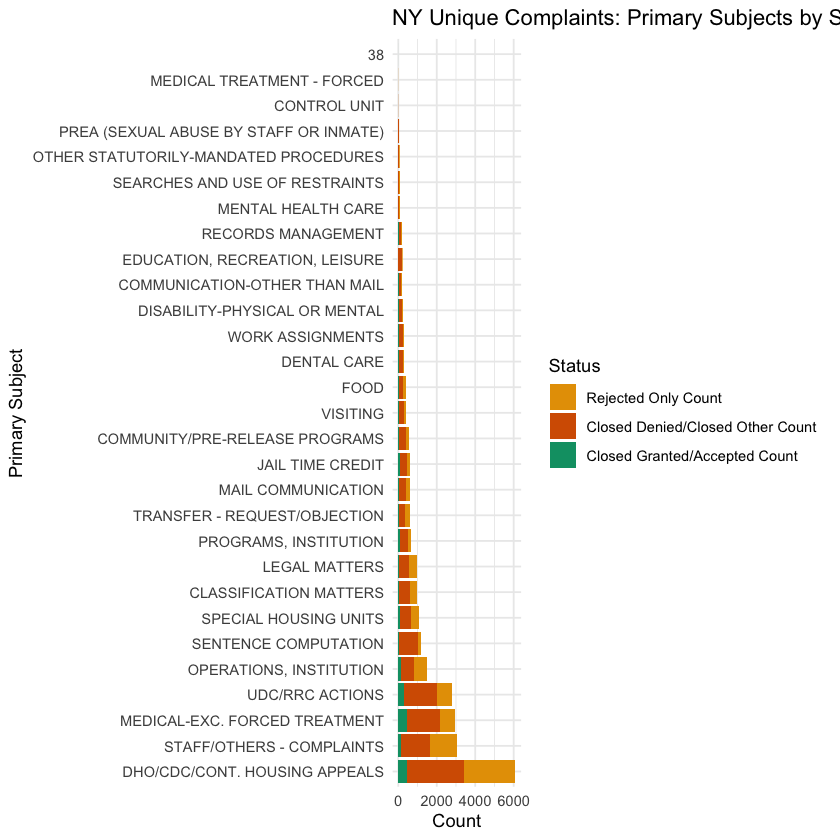

In [101]:
# STEP 5: Visualization for primary remedy code analysis

# Convert the analysis data from wide format to long format for easier plotting
analysis_long <- analysis %>%
  pivot_longer(
    cols = c(`Closed Granted/Accepted Count`, `Closed Denied/Closed Other Count`, `Rejected Only Count`),
    names_to = "Status",
    values_to = "Count"
  )

# Set order of the Status variable
analysis_long <- analysis_long %>%
  mutate(Status = factor(Status, levels = c("Rejected Only Count", "Closed Denied/Closed Other Count", "Closed Granted/Accepted Count")))

# Select colors
color_mapping <- c(
  "Rejected Only Count" = "#E69F00",  # Orange
  "Closed Denied/Closed Other Count" = "#D55E00",  # Red
  "Closed Granted/Accepted Count" = "#009E73"  # Green
)

# Create barplot using ggplot
complaint_plot <- ggplot(analysis_long, aes(x = reorder(`Primary.Remedy.Subject`, -`Unique Complaint Count`), # Reorder subjects by descending Unique Complaint Count
                                            y = Count, fill = Status)) +
  geom_bar(stat = "identity") + # Create bars with height corresponding to the Count values
  coord_flip() + # Flip the axes for a horizontal bar chart
  scale_fill_manual(values = color_mapping) +  # Apply custom color mapping
  labs(
    title = "NY Unique Complaints: Primary Subjects by Status (Jan 2000-May 2024)",
    x = "Primary Subject",
    y = "Count",
    fill = "Status"
  ) +
  theme_minimal()

# Save the plot to a PNG file 
ggsave(
  filename = paste0("../results/analysis/NY_PrimarySubjectByStatus.png"),
  width = 16, 
  height = 6,
  units = "in"
)

# Print the plot
print(complaint_plot)

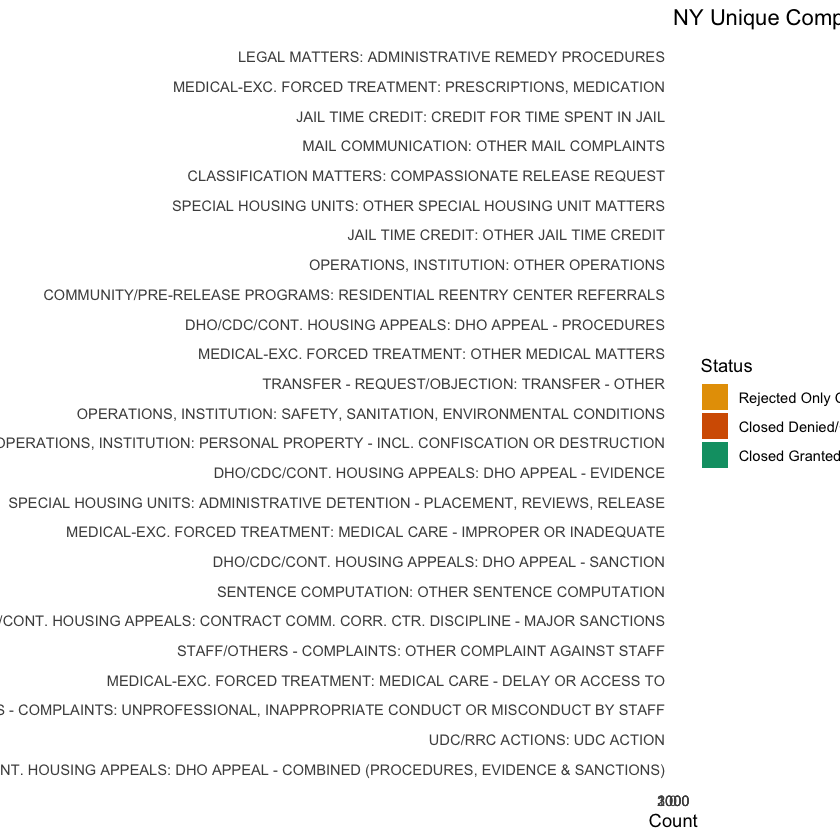

In [102]:
# STEP 6: Visualization for secondary remedy code analysis (top 25)

# Convert the analysis data from wide format to long format for easier plotting
analysis_secondary_long <- analysis_secondary %>%
  # Select only the top 25 Remedy.Subject.Code.Translation by Unique Complaint Count
  slice_max(order_by = `Unique Complaint Count`, n = 25) %>%
  pivot_longer(
    cols = c(`Closed Granted/Accepted Count`, `Closed Denied/Closed Other Count`, `Rejected Only Count`),
    names_to = "Status",  
    values_to = "Count"  
  )

# Set the desired order of the Status variable
analysis_secondary_long <- analysis_secondary_long %>%
  mutate(Status = factor(Status, levels = c("Rejected Only Count", "Closed Denied/Closed Other Count", "Closed Granted/Accepted Count")))

# Define the color mapping
color_mapping <- c(
  "Rejected Only Count" = "#E69F00",  # Orange
  "Closed Denied/Closed Other Count" = "#D55E00",  # Red
  "Closed Granted/Accepted Count" = "#009E73"  # Green
)

# Create a barplot using ggplot for secondary subjects
complaint_secondary_plot <- ggplot(analysis_secondary_long, aes(x = reorder(`Remedy.Subject.Code.Translation`, -`Unique Complaint Count`), 
                                                                y = Count, fill = Status)) +
  geom_bar(stat = "identity") +  # Create bars with height corresponding to the Count values
  coord_flip() +  # Flip the axes for a horizontal bar chart
  scale_fill_manual(values = color_mapping) +  # Apply custom color mapping
  labs(
    title = "NY Unique Complaints: Top 25 Secondary Subjects by Status (Jan 2000-May 2024)",
    x = "Secondary Remedy Subject",  # Label for x-axis
    y = "Count",  # Label for y-axis
    fill = "Status"  # Legend title
  ) +
  theme_minimal()

# Save the plot to a PNG file
ggsave(
  filename = paste0("../results/analysis/NY_SecondarySubjectByStatus.png"), 
  width = 16,  # Width of the image
  height = 6,  # Height of the image
  units = "in"  # Dimensions in inches
)

# Print the plot
print(complaint_secondary_plot)


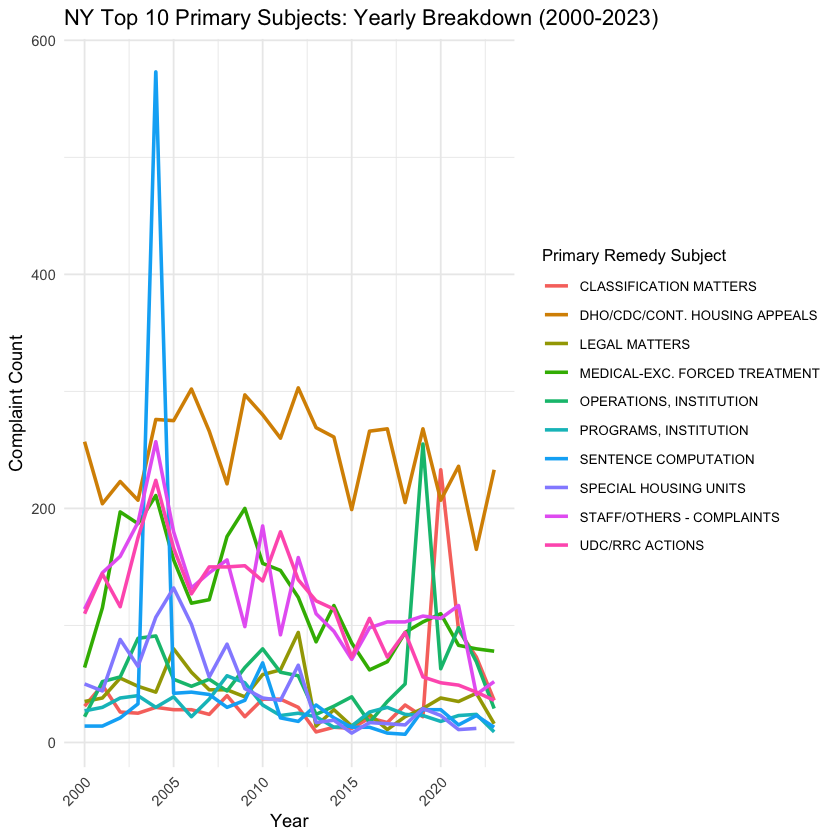

In [28]:
# STEP 7: Visualization for top 10 complaint subjects (primary subjects) for all unique complaints. shows the number of complaints made per year from 2000-2023

# Ensure 'Remedy Case Submission date received' is in Date format
uniquesubmissions <- uniquesubmissions %>%
  mutate(Remedy.Case.Submission.date.received = as.Date(Remedy.Case.Submission.date.received, format = "%Y-%m-%d"))

# Extract year from the submission date as number
uniquesubmissions <- uniquesubmissions %>%
  mutate(Year = as.numeric(format(Remedy.Case.Submission.date.received, "%Y")))

# Find the top 10 complaint types by primary code
top_primary_complaints <- uniquesubmissions %>%
  count(Primary.Remedy.Subject, sort = TRUE) %>%
  slice_head(n = 10) %>%
  pull(Primary.Remedy.Subject)

# Filter the dataset for only top 10 primary complaints
top_primary_complaints_data <- uniquesubmissions %>%
  filter(Primary.Remedy.Subject %in% top_primary_complaints)

# Summarize complaints per year
primary_complaints_by_year <- top_primary_complaints_data %>%
  group_by(Year, Primary.Remedy.Subject) %>%
  summarize(Complaint_Count = n(), .groups = "drop")

# Exclude 2024 (since year is not complete)
primary_complaints_by_year <- primary_complaints_by_year %>%
  filter(Year < 2024)

# Create the line graph
top_primary_complaints_plot <- ggplot(primary_complaints_by_year, aes(x = Year, y = Complaint_Count, color = `Primary.Remedy.Subject`, group = `Primary.Remedy.Subject`)) +
  geom_line(size = 1) +
  labs(
    title = "NY Top 10 Primary Subjects: Yearly Breakdown (2000-2023)",
    x = "Year",
    y = "Complaint Count",
    color = "Primary Remedy Subject"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",  # Move legend to the right
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 8),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Save the plot
ggsave(
  filename = paste0("../results/analysis/NY_PrimarySubjectsYearlyBreakdown.png"),
  plot = top_primary_complaints_plot,
  width = 14,
  height = 8,
  units = "in"
)

# Print the plot
print(top_primary_complaints_plot)

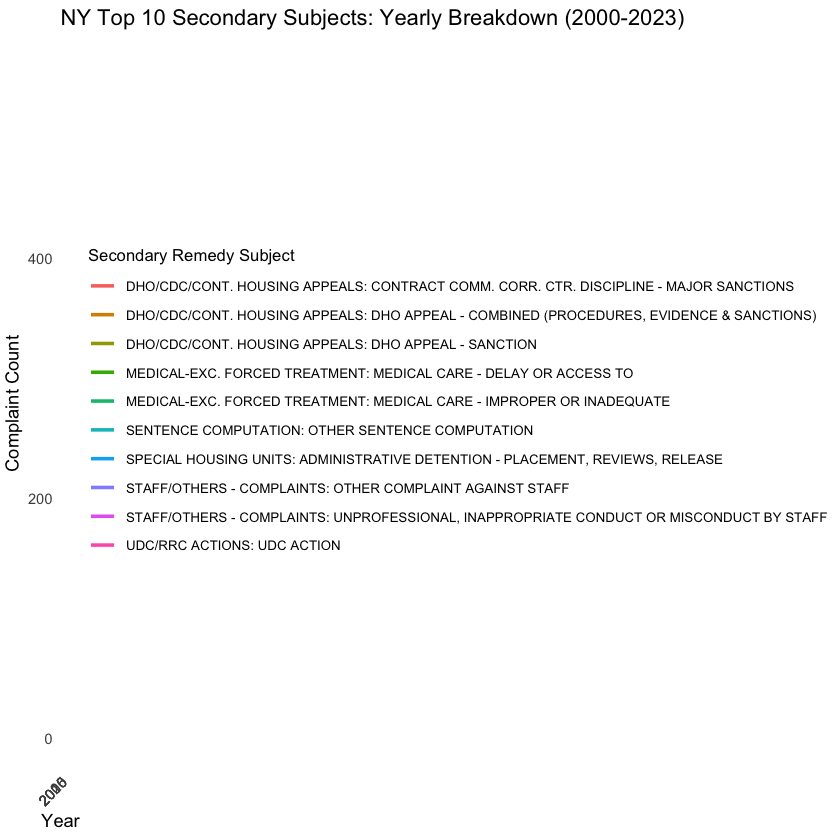

In [27]:
# STEP 8: Visualization for top 10 complaint subjects (secondary subjects) for all unique complaints. shows the number of complaints made per year from 2000-2023

# Ensure 'Remedy Case Submission date received' is in Date format
uniquesubmissions <- uniquesubmissions %>%
  mutate(Remedy.Case.Submission.date.received = as.Date(Remedy.Case.Submission.date.received, format = "%Y-%m-%d"))

# Extract year from the submission date as number
uniquesubmissions <- uniquesubmissions %>%
  mutate(Year = as.numeric(format(Remedy.Case.Submission.date.received, "%Y")))

# Find the top 10 complaint types by primary code
top_secondary_complaints <- uniquesubmissions %>%
  count(Remedy.Subject.Code.Translation, sort = TRUE) %>%
  slice_head(n = 10) %>%
  pull(Remedy.Subject.Code.Translation)

# Filter the dataset for only top 10 primary complaints
top_secondary_complaints_data <- uniquesubmissions %>%
  filter(Remedy.Subject.Code.Translation %in% top_secondary_complaints)

# Summarize complaints per year
secondary_complaints_by_year <- top_secondary_complaints_data %>%
  group_by(Year, Remedy.Subject.Code.Translation) %>%
  summarize(Complaint_Count = n(), .groups = "drop")

# Exclude 2024 (since year is not complete)
secondary_complaints_by_year <- secondary_complaints_by_year %>%
  filter(Year < 2024)

# Create the line graph
top_secondary_complaints_plot <- ggplot(secondary_complaints_by_year, aes(x = Year, y = Complaint_Count, color = `Remedy.Subject.Code.Translation`, group = `Remedy.Subject.Code.Translation`)) +
  geom_line(size = 1) +
  labs(
    title = "NY Top 10 Secondary Subjects: Yearly Breakdown (2000-2023)",
    x = "Year",
    y = "Complaint Count",
    color = "Secondary Remedy Subject"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",  # Move legend to the right
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 8),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Save the plot
ggsave(
  filename = paste0("../results/analysis/NY_SecondarySubjectsYearlyBreakdown.png"),
  plot = top_secondary_complaints_plot,
  width = 14,
  height = 8,
  units = "in"
)

# Print the plot
print(top_secondary_complaints_plot)